In [1]:
import os

from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
load_dotenv()

client = MongoClient(os.getenv("MONGO_CONNECTION_STRING"))
print("Connected to MongoDB")

db = client[os.getenv("MONGO_DB_NAME")]

env_type = os.getenv("ENV_TYPE")
print("env:", env_type)

if env_type == "dev":
    collection_name = os.getenv("DEV_MONGO_COLLECTION")
    print("Using dev collection")
else:
    collection_name = os.getenv("PROD_MONGO_COLLECTION")
    print("Using prod collection")

collection = db[collection_name]
print("Using collection:", collection_name)

Connected to MongoDB
env: prod
Using prod collection
Using collection: Results


In [3]:
cursor = collection.find({})
data = list(cursor)

results = {
    "gpt-4o": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "gemini-1.5-pro": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "gemini-2.0-flash": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "claude-3-5-sonnet-20241022": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "claude-3-7-sonnet-latest": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
}

for d in data:
    model = d["model"]
    results[model]["question_correct"].append(d["question_correct"])
    results[model]["answers_correct"].append(d["answers_correct"])
    results[model]["interesting_question"].append(d["interesting_question"])

In [4]:
stats = {}

for model, categories in results.items():
    model_stats = {}

    # Combine all evaluations across categories for summary statistics
    all_values = []

    # Calculate mean for each category
    for category, values in categories.items():
        model_stats[f"{category}_mean"] = np.mean(values)
        all_values.extend(values)

    # Calculate overall statistics
    model_stats["overall_mean"] = np.mean(all_values)
    model_stats["median"] = np.median(all_values)
    model_stats["percentile_75"] = np.percentile(all_values, 75)
    model_stats["min"] = np.min(all_values)
    model_stats["max"] = np.max(all_values)

    stats[model] = model_stats

# Create a pandas DataFrame from the stats dictionary
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Reorder columns for better readability
column_order = [
    "question_correct_mean",
    "answers_correct_mean",
    "interesting_question_mean",
    "overall_mean",
    "median",
    "percentile_75",
    "min",
    "max"
]
df_stats = df_stats[column_order]

# Round values to 2 decimal places for better readability
df_stats = df_stats.round(2)

# Display the results
df_stats

,question_correct_mean,answers_correct_mean,interesting_question_mean,overall_mean,median,percentile_75,min,max
gpt-4o,0.79,0.67,0.71,0.72,1.0,2.0,-2,2
gemini-1.5-pro,0.77,0.73,0.62,0.71,1.0,2.0,-2,2
gemini-2.0-flash,0.77,0.87,0.64,0.76,1.0,2.0,-2,2
claude-3-5-sonnet-20241022,0.87,0.85,0.91,0.88,1.0,2.0,-2,2
claude-3-7-sonnet-latest,0.91,0.98,1.00,0.96,1.0,2.0,-2,2


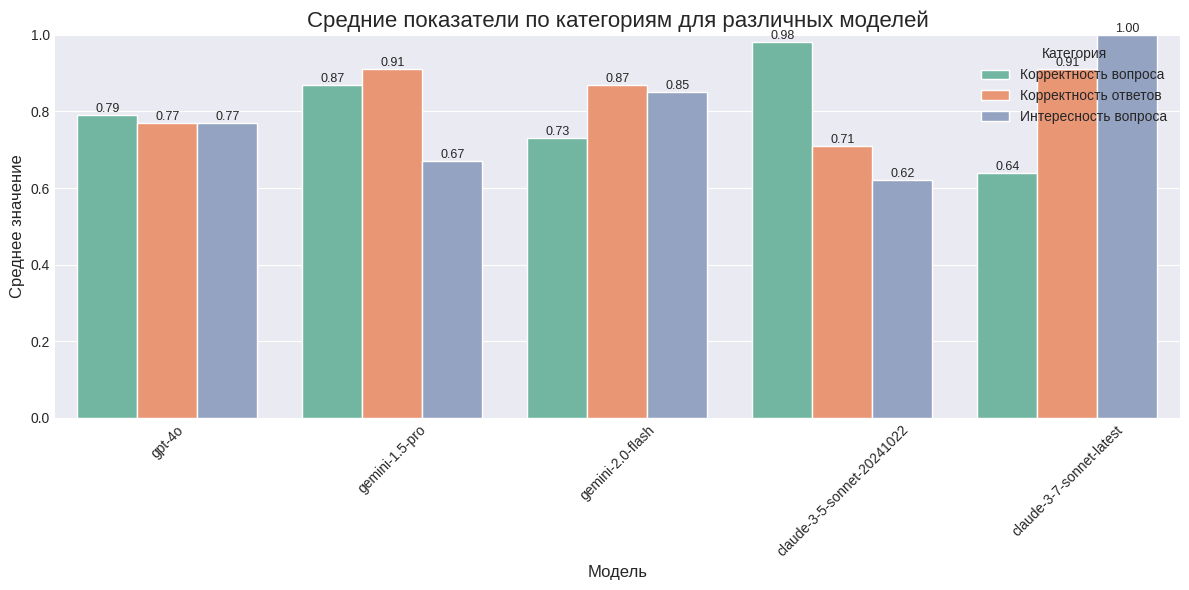

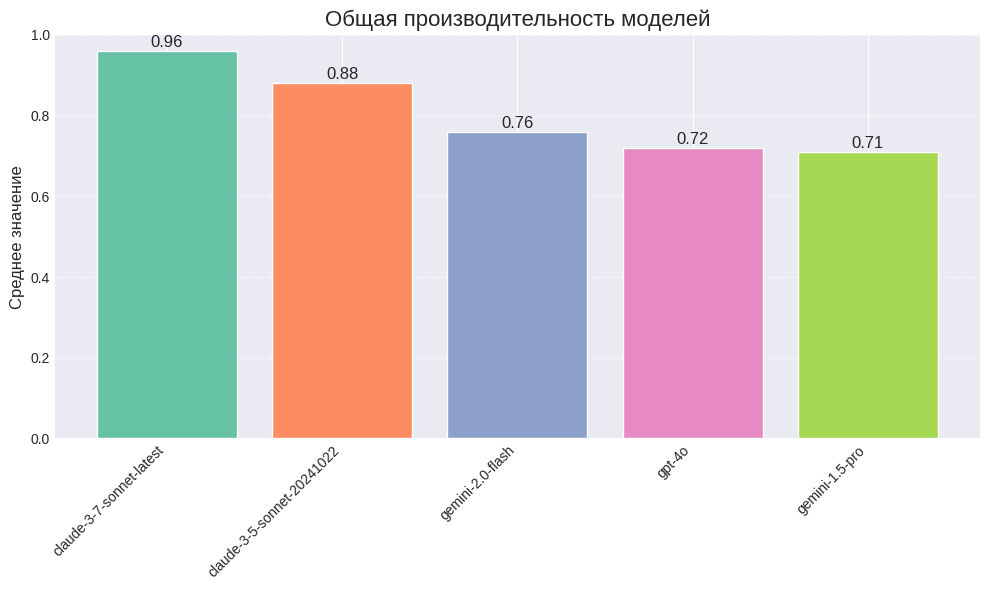

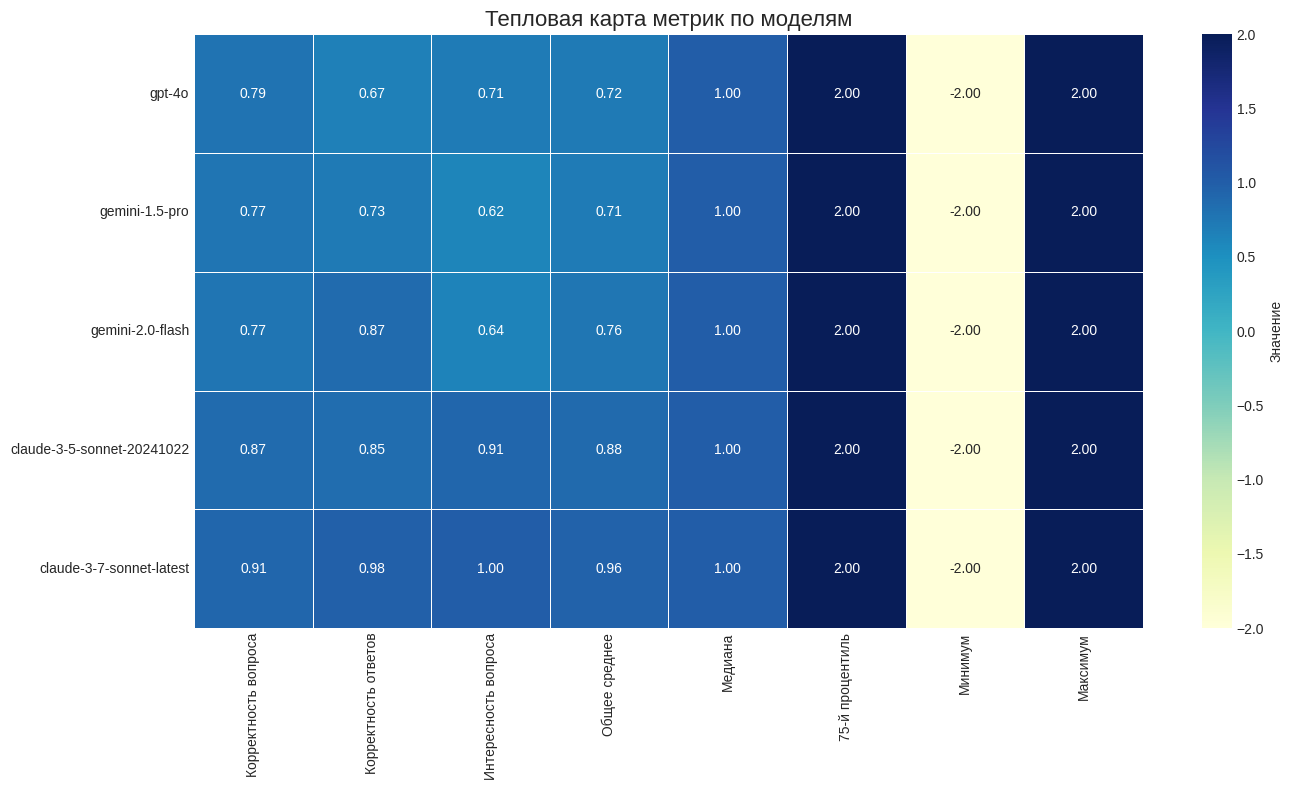

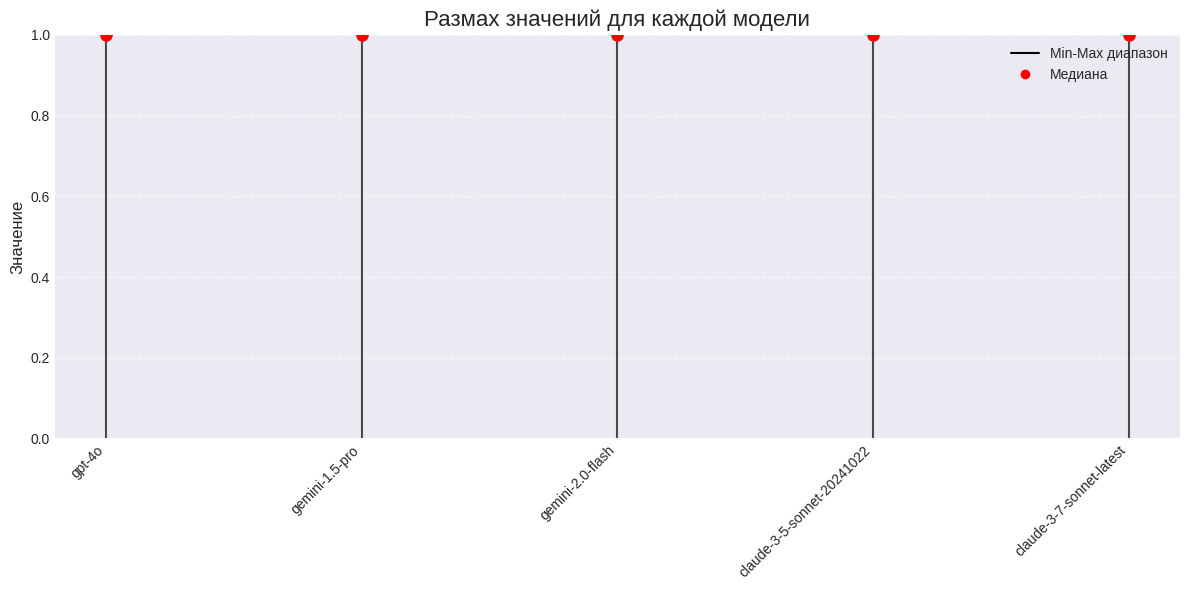

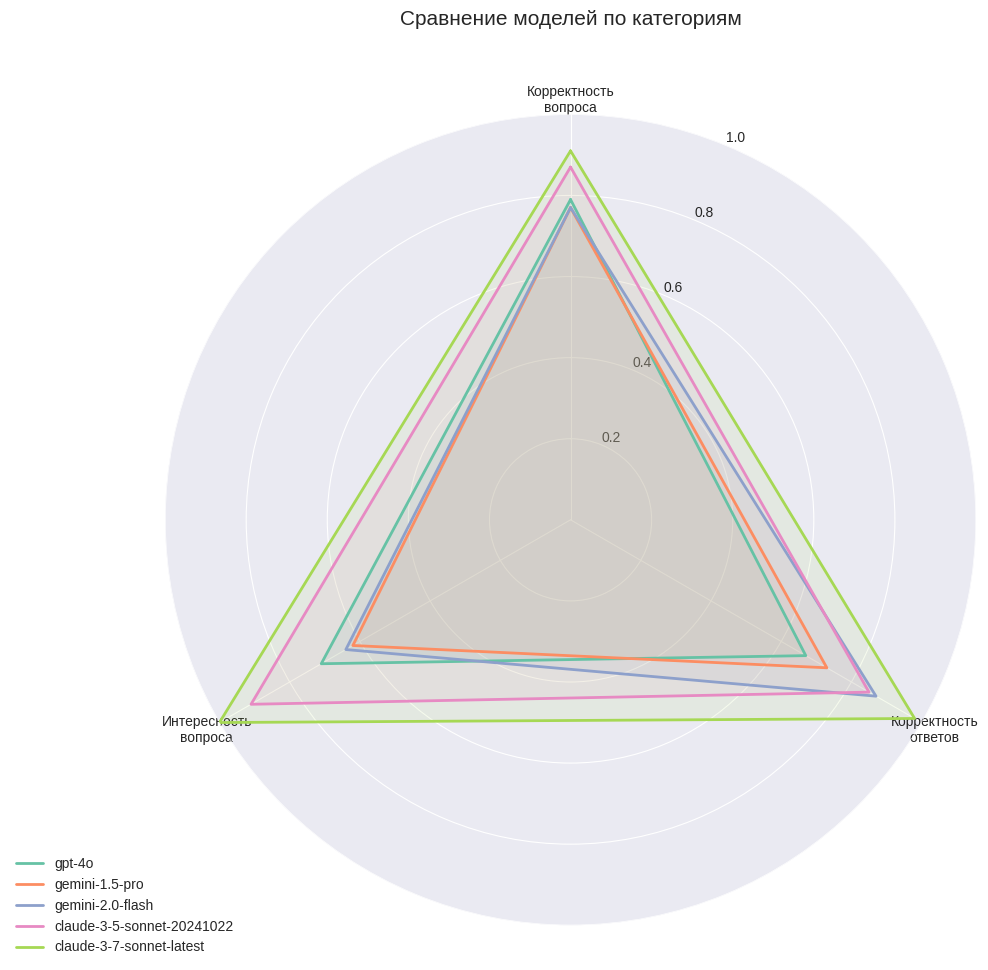

Все визуализации сохранены в текущей директории.


/tmp/ipykernel_112742/560587597.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_112742/560587597.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


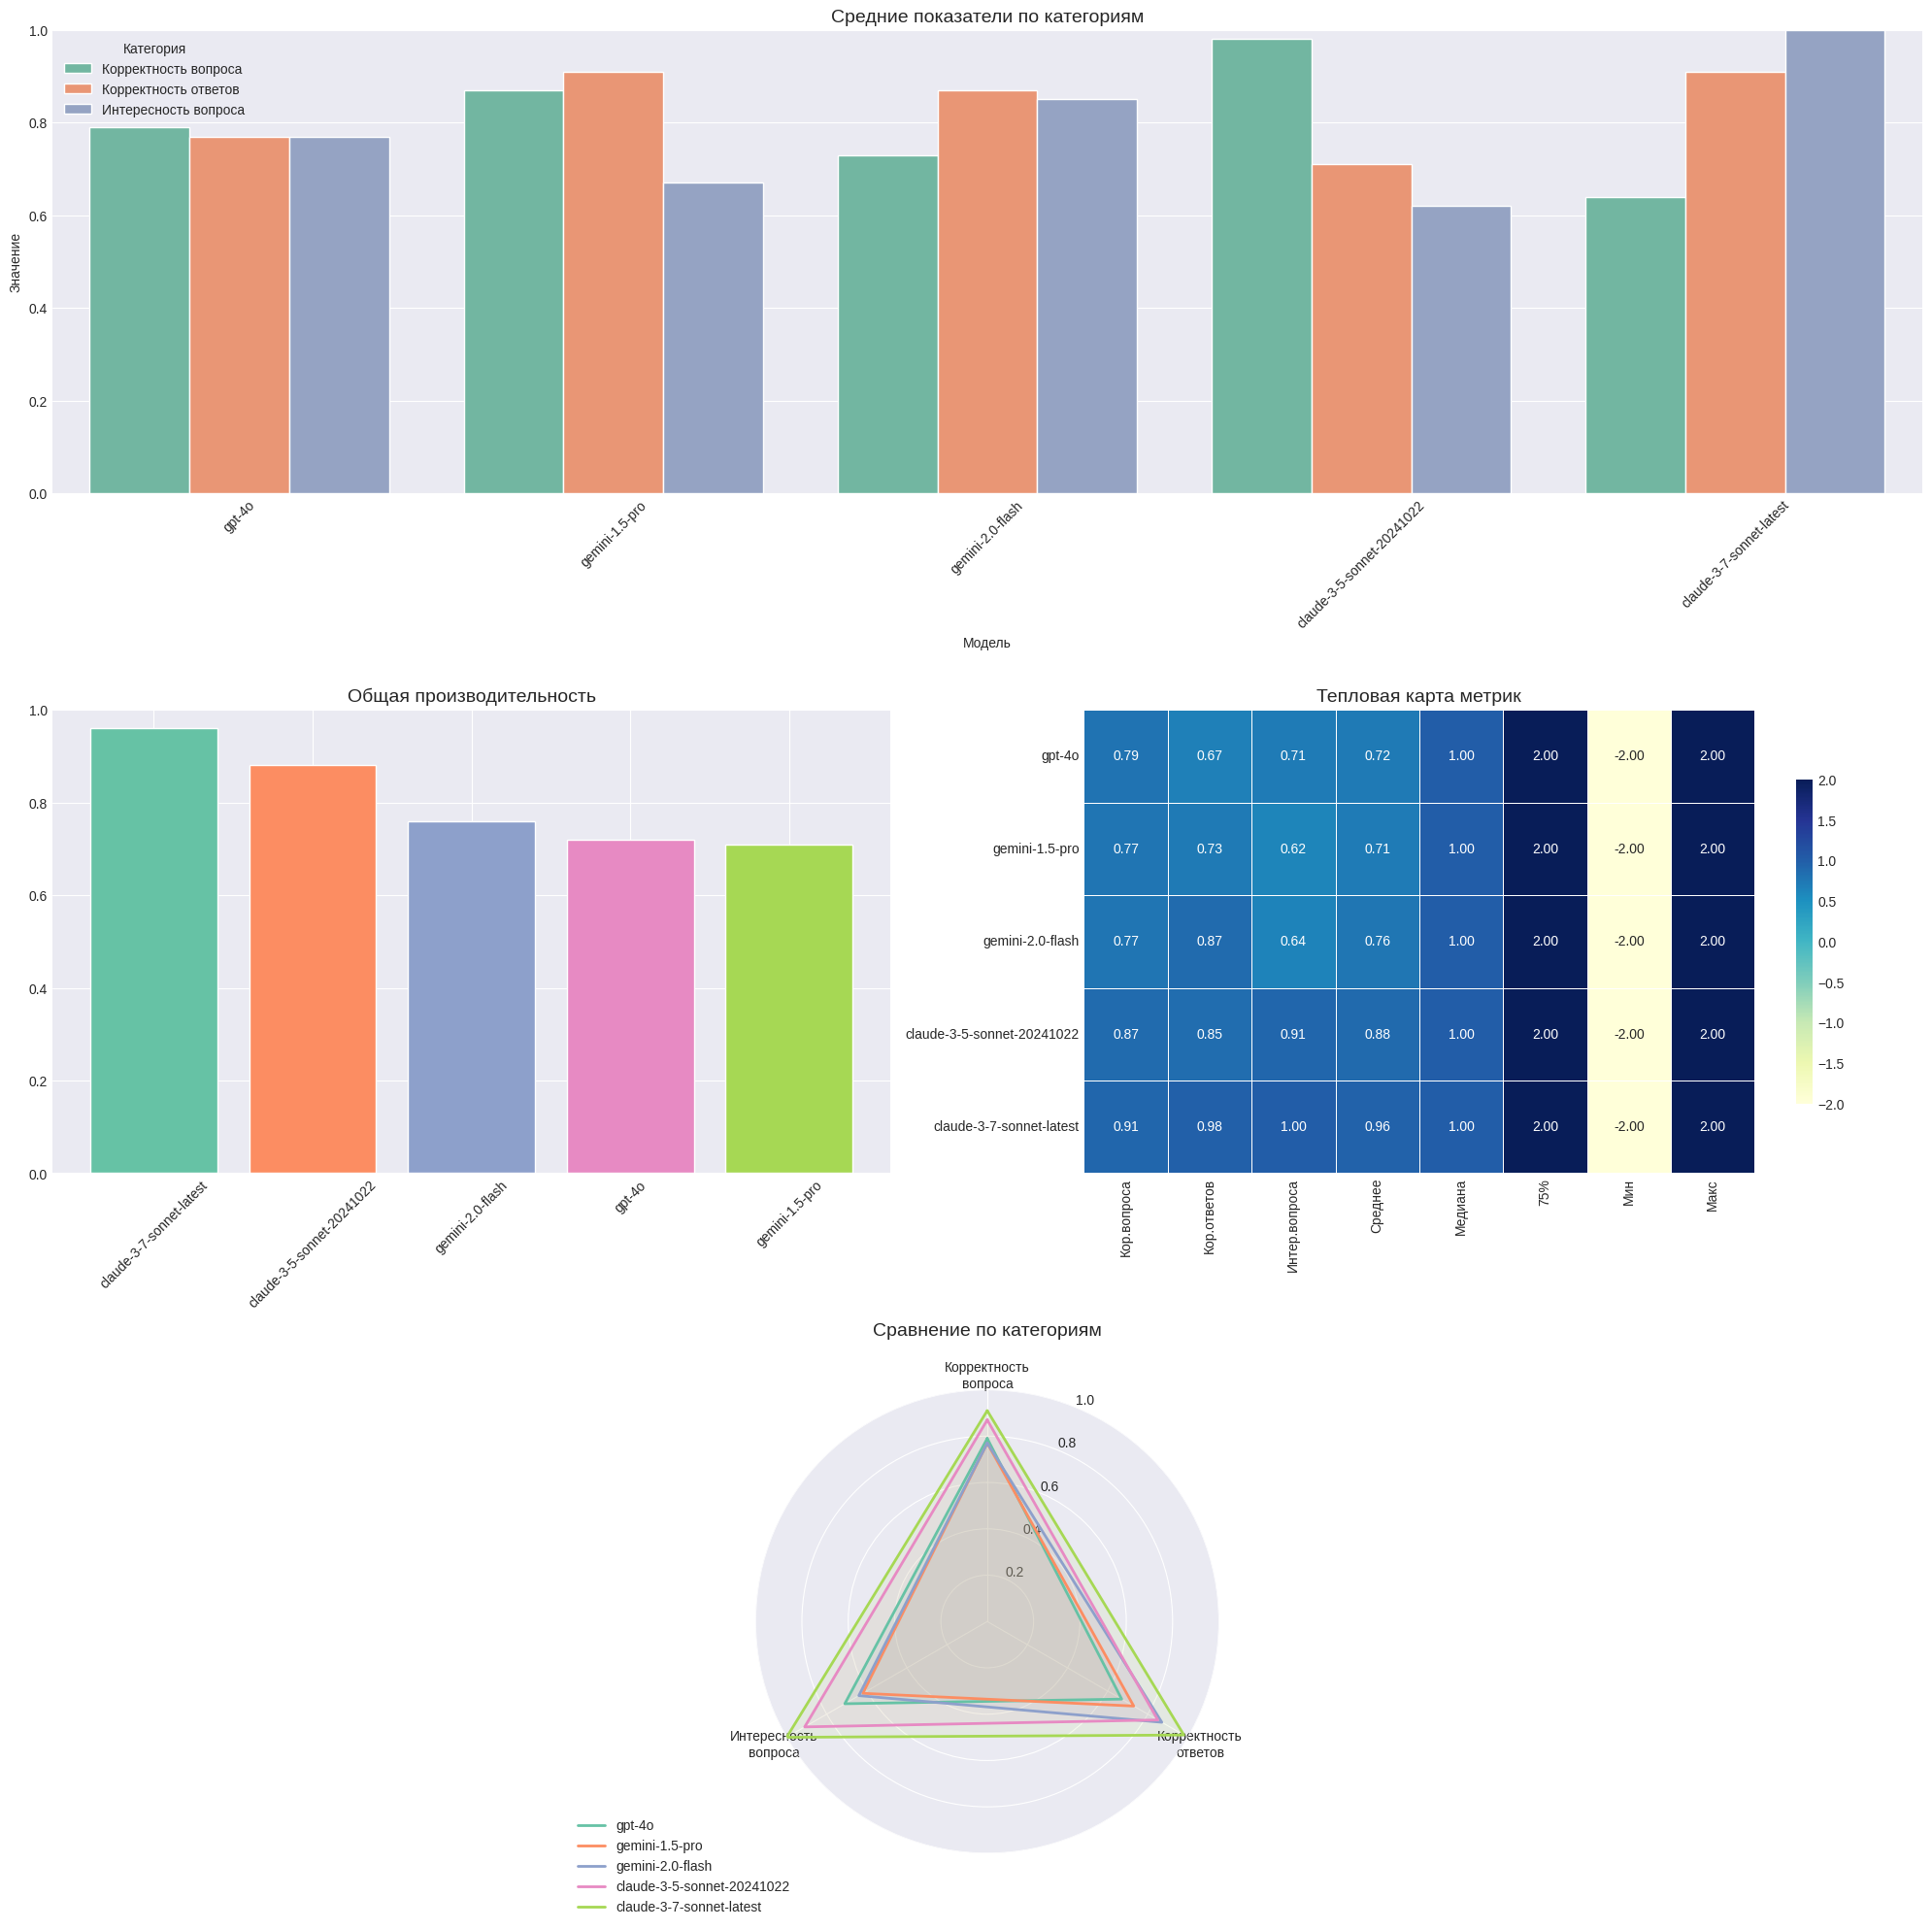

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Предполагаем, что у нас уже есть DataFrame df_stats из предыдущего кода

# Настраиваем стиль визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# 1. Создаем график сравнения средних значений по категориям
def plot_category_means(df):
    # Преобразуем данные для удобства визуализации
    categories = ['question_correct_mean', 'answers_correct_mean', 'interesting_question_mean']
    category_names = ['Корректность вопроса', 'Корректность ответов', 'Интересность вопроса']

    # Создаем новый DataFrame для построения графика
    plot_data = pd.DataFrame({
        'Модель': df.index.repeat(len(categories)),
        'Категория': np.tile(category_names, len(df)),
        'Значение': np.concatenate([df[cat].values for cat in categories])
    })

    plt.figure(figsize=(12, 6))

    # Используем grouped bar chart
    ax = sns.barplot(x='Модель', y='Значение', hue='Категория', data=plot_data)

    # Настраиваем внешний вид
    plt.title('Средние показатели по категориям для различных моделей', fontsize=16)
    plt.ylabel('Среднее значение', fontsize=12)
    plt.xlabel('Модель', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)

    # Добавляем значения над столбцами
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9)

    plt.tight_layout()
    plt.savefig('category_means_comparison.png', dpi=300)
    plt.show()

# 2. Создаем график общей производительности (overall_mean)
def plot_overall_performance(df):
    plt.figure(figsize=(10, 6))

    # Сортируем модели по общей производительности
    sorted_df = df.sort_values('overall_mean', ascending=False)

    # Используем разные цвета для визуального различия
    bars = plt.bar(sorted_df.index, sorted_df['overall_mean'], color=sns.color_palette("Set2", len(df)))

    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', fontsize=12)

    plt.title('Общая производительность моделей', fontsize=16)
    plt.ylabel('Среднее значение', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('overall_performance.png', dpi=300)
    plt.show()

# 3. Создаем тепловую карту для всех метрик
def plot_heatmap(df):
    plt.figure(figsize=(14, 8))

    # Изменяем названия столбцов для более читаемой тепловой карты
    column_names = {
        'question_correct_mean': 'Корректность вопроса',
        'answers_correct_mean': 'Корректность ответов',
        'interesting_question_mean': 'Интересность вопроса',
        'overall_mean': 'Общее среднее',
        'median': 'Медиана',
        'percentile_75': '75-й процентиль',
        'min': 'Минимум',
        'max': 'Максимум'
    }

    df_heatmap = df.copy()
    df_heatmap.columns = [column_names[col] for col in df.columns]

    # Создаем тепловую карту
    sns.heatmap(df_heatmap, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5,
                cbar_kws={'label': 'Значение'})

    plt.title('Тепловая карта метрик по моделям', fontsize=16)
    plt.tight_layout()
    plt.savefig('metrics_heatmap.png', dpi=300)
    plt.show()

# 4. Создаем график размаха (min, median, max) для каждой модели
def plot_min_max_range(df):
    plt.figure(figsize=(12, 6))

    # Для каждой модели показываем размах значений
    for i, model in enumerate(df.index):
        min_val = df.loc[model, 'min']
        median_val = df.loc[model, 'median']
        max_val = df.loc[model, 'max']

        plt.plot([i, i], [min_val, max_val], 'k-', alpha=0.7)
        plt.plot(i, median_val, 'ro', markersize=8)

    plt.title('Размах значений для каждой модели', fontsize=16)
    plt.ylabel('Значение', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(len(df.index)), df.index, rotation=45, ha='right')
    plt.ylim(0, 1.0)

    # Добавляем легенду
    plt.plot([], [], 'k-', label='Min-Max диапазон')
    plt.plot([], [], 'ro', label='Медиана')
    plt.legend()

    plt.tight_layout()
    plt.savefig('min_max_range.png', dpi=300)
    plt.show()

# 5. Радарный график для сравнения категорий
def plot_radar_chart(df):
    # Подготовка данных для радарного графика
    categories = ['question_correct_mean', 'answers_correct_mean', 'interesting_question_mean']
    category_names = ['Корректность\nвопроса', 'Корректность\nответов', 'Интересность\nвопроса']

    # Количество переменных
    N = len(categories)

    # Создаем угол для каждой переменной на графике
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Замыкаем круг

    # Создаем фигуру
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Добавляем линии для каждой модели
    for i, model in enumerate(df.index):
        values = df.loc[model, categories].tolist()
        values += values[:1]  # Замыкаем значения

        # Рисуем линию
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)

    # Настраиваем радарный график
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Устанавливаем метки
    plt.xticks(angles[:-1], category_names)

    # Устанавливаем границы y
    ax.set_ylim(0, 1)

    # Добавляем легенду и заголовок
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Сравнение моделей по категориям', fontsize=15, y=1.1)

    plt.tight_layout()
    plt.savefig('radar_chart.png', dpi=300)
    plt.show()

# Запуск всех визуализаций
def generate_all_visualizations(df_stats):
    plot_category_means(df_stats)
    plot_overall_performance(df_stats)
    plot_heatmap(df_stats)
    plot_min_max_range(df_stats)
    plot_radar_chart(df_stats)

    print("Все визуализации сохранены в текущей директории.")

# Запускаем все визуализации
generate_all_visualizations(df_stats)

# Дополнительно: можно создать функцию для объединения всех графиков в одну фигуру
def create_combined_report(df_stats):
    # Создаем фигуру с несколькими подграфиками
    fig = plt.figure(figsize=(20, 20))

    # Настройка размещения графиков
    gs = fig.add_gridspec(3, 2)

    # График средних значений по категориям
    ax1 = fig.add_subplot(gs[0, :])
    categories = ['question_correct_mean', 'answers_correct_mean', 'interesting_question_mean']
    category_names = ['Корректность вопроса', 'Корректность ответов', 'Интересность вопроса']

    plot_data = pd.DataFrame({
        'Модель': df_stats.index.repeat(len(categories)),
        'Категория': np.tile(category_names, len(df_stats)),
        'Значение': np.concatenate([df_stats[cat].values for cat in categories])
    })

    sns.barplot(x='Модель', y='Значение', hue='Категория', data=plot_data, ax=ax1)
    ax1.set_title('Средние показатели по категориям', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylim(0, 1.0)

    # Общая производительность
    ax2 = fig.add_subplot(gs[1, 0])
    sorted_df = df_stats.sort_values('overall_mean', ascending=False)
    ax2.bar(sorted_df.index, sorted_df['overall_mean'], color=sns.color_palette("Set2", len(df_stats)))
    ax2.set_title('Общая производительность', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylim(0, 1.0)

    # Тепловая карта
    ax3 = fig.add_subplot(gs[1, 1])
    column_names = {
        'question_correct_mean': 'Кор.вопроса',
        'answers_correct_mean': 'Кор.ответов',
        'interesting_question_mean': 'Интер.вопроса',
        'overall_mean': 'Среднее',
        'median': 'Медиана',
        'percentile_75': '75%',
        'min': 'Мин',
        'max': 'Макс'
    }

    df_heatmap = df_stats.copy()
    df_heatmap.columns = [column_names[col] for col in df_stats.columns]

    sns.heatmap(df_heatmap, annot=True, fmt='.2f', cmap='YlGnBu',
                linewidths=0.5, ax=ax3, cbar_kws={'shrink': 0.7})
    ax3.set_title('Тепловая карта метрик', fontsize=14)

    # Радарный график
    ax4 = fig.add_subplot(gs[2, :], polar=True)
    categories = ['question_correct_mean', 'answers_correct_mean', 'interesting_question_mean']
    category_names = ['Корректность\nвопроса', 'Корректность\nответов', 'Интересность\nвопроса']

    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    for i, model in enumerate(df_stats.index):
        values = df_stats.loc[model, categories].tolist()
        values += values[:1]
        ax4.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax4.fill(angles, values, alpha=0.1)

    ax4.set_theta_offset(np.pi / 2)
    ax4.set_theta_direction(-1)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(category_names)
    ax4.set_ylim(0, 1)
    ax4.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax4.set_title('Сравнение по категориям', fontsize=14, y=1.1)

    plt.tight_layout()
    plt.savefig('combined_report.png', dpi=300)
    plt.show()

# Создаем объединенный отчет
create_combined_report(df_stats)